# Photometric calibration: fitting a stellar spectrum

The 2MASS photometry of PZ Tel A is fitted with a [IRTF spectrum](http://irtfweb.ifa.hawaii.edu/~spex/IRTF_Spectral_Library/References_files/G.html) of a G8V type star. With the best-fit scaling parameter, synthetic photometry is calculated for the VLT/SPHERE H2 filter.

## Getting started

The required modules are imported, *species* is initiated, and an object of `Database` is created.

In [1]:
import urllib.request
import species
from IPython.display import Image

In [2]:
species.SpeciesInit()

Initiating species v0.1.4... [DONE]
Creating species_config.ini... [DONE]
Database: /Users/tomasstolker/applications/species/docs/tutorials/species_database.hdf5
Data folder: /Users/tomasstolker/applications/species/docs/tutorials/data
Working folder: /Users/tomasstolker/applications/species/docs/tutorials
Creating species_database.hdf5... [DONE]
Creating data folder... [DONE]


In [3]:
database = species.Database()

The distance and certainty of PZ Tel are defined and a dictionary with the 2MASS magnitudes is created.

In [4]:
distance = (47.13, 0.13)  # [pc]

In [5]:
magnitudes = {'2MASS/2MASS.J':(6.856, 0.021),
              '2MASS/2MASS.H':(6.486, 0.049),
              '2MASS/2MASS.Ks':(6.366, 0.024)}

Also a list with the filter names is created.

In [6]:
filters = list(magnitudes.keys())

## Adding an object and calibration spectrum

The distance and magnitudes are of PZ Tel A are stored in the database as object.

In [7]:
database.add_object(object_name='PZ Tel A',
                    distance=distance,
                    app_mag=magnitudes,
                    spectrum=None)

Adding filter: 2MASS/2MASS.J... [DONE]
Adding Vega spectrum... [DONE]
Adding filter: 2MASS/2MASS.H... [DONE]
Adding filter: 2MASS/2MASS.Ks... [DONE]
Adding object: PZ Tel A... [DONE]


A G8V type spectrum is downloaded from the IRTF website.

In [8]:
urllib.request.urlretrieve('http://irtfweb.ifa.hawaii.edu/~spex/IRTF_Spectral_Library/Data/G8V_HD75732.txt',
                           'data/G8V_HD75732.txt')

('data/G8V_HD75732.txt', <http.client.HTTPMessage at 0x127c69240>)

And stored as calibration data in de database.

In [9]:
database.add_calibration(filename='data/G8V_HD75732.txt',
                         tag='G8V_HD75732')

Adding calibration spectrum: G8V_HD75732... [DONE]


## Fitting the stellar spectrum

The stellar spectrum is fitted to the 2MASS fluxes with a scaling parameter. The boundaries for the uniform prior is provided as dictionary.

In [10]:
fit = species.FitSpectrum(object_name='PZ Tel A',
                          filters=None,
                          spectrum='G8V_HD75732',
                          bounds={'scaling':(0., 1e0)})

Getting object: PZ Tel A... [DONE]


The posterior distribution are estimated with the MCMC ensemble sampler of [*emcee*](https://emcee.readthedocs.io/en/stable/).

In [11]:
fit.run_mcmc(nwalkers=200,
             nsteps=1000,
             guess={'scaling':5e-1},
             tag='pztel')

Running MCMC...


100%|██████████| 1000/1000 [00:02<00:00, 391.50it/s]


Mean acceptance fraction: 0.787
Integrated autocorrelation time = [3575.53872865]


## Plotting the results

Let's plot the evolution of the walkers.

In [12]:
species.plot_walkers(tag='pztel',
                     nsteps=None,
                     offset=(-0.2, -0.08),
                     output='walkers.png')

Plotting walkers: walkers.png... [DONE]


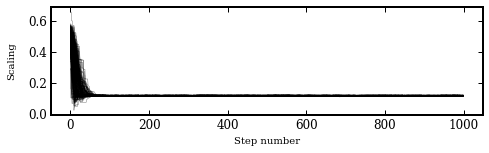

In [13]:
Image('walkers.png')

And the posterior distribution of the scaling parameter.

In [14]:
species.plot_posterior(tag='pztel',
                       burnin=500,
                       offset=(-0.3, -0.10),
                       title_fmt='.4f',
                       output='posterior.png')

Median sample:
   - scaling = 0.12
Plotting the posterior: posterior.png... [DONE]


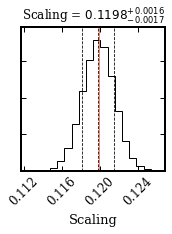

In [15]:
Image('posterior.png')

For plotting the spectrum, the data of PZ Tel A are stored in an `ObjectBox`.

In [16]:
objectbox = database.get_object(object_name='PZ Tel A',
                                filters=None)

Getting object: PZ Tel A... [DONE]


Next, 30 randomly selected samples from the posterior are used for creating comparison spectra.

In [17]:
samples = database.get_mcmc_spectra(tag='pztel',
                                    burnin=500,
                                    random=30,
                                    wavel_range=(0.1, 50.0),
                                    spec_res=None)

Getting MCMC spectra: 100%|██████████| 30/30 [00:00<00:00, 540.12it/s]

The smooth_spectrum function has not been fully tested. [WARNING]


And also the best-fit value is extracted as the median of the posterior distribution.

In [18]:
median = database.get_median_sample(tag='pztel',
                                    burnin=500)

Let's have a look at the value.

In [19]:
print(median)

{'scaling': 0.11984761895274632}


With this value, the best-fit spectrum is calculated.

In [20]:
readcalib = species.ReadCalibration(tag='G8V_HD75732',
                                    filter_name=None)

In [21]:
spectrum = readcalib.get_spectrum(model_param=median)

The best-fit value is also used for creating synthetic photometry in the 2MASS filters.

In [22]:
synphot = species.multi_photometry(datatype='calibration',
                                   spectrum='G8V_HD75732',
                                   filters=filters,
                                   parameters=median)

Calculating synthetic photometry... [DONE]


The difference between the data and the best-fit synthetic photometry is stored in a `ResidualsBox`.

In [23]:
residuals = species.get_residuals(datatype='calibration',
                                  spectrum='G8V_HD75732',
                                  parameters=median,
                                  filters=filters,
                                  objectbox=objectbox,
                                  inc_phot=True,
                                  inc_spec=False)

Calculating synthetic photometry... [DONE]
Calculating residuals... [DONE]
Residuals [sigma]:
   - 2MASS/2MASS.J: 0.03
   - 2MASS/2MASS.H: -0.57
   - 2MASS/2MASS.Ks: 0.28


Finally, all the boxes are provide as input to the `plot_spectrum` function.

In [24]:
species.plot_spectrum(boxes=[samples, spectrum, objectbox, synphot],
                      filters=filters,
                      colors=['gray', 'black', ('black', None), 'black'],
                      residuals=residuals,
                      xlim=(1., 2.5),
                      ylim=(-1.5e-12, 1.1e-11),
                      scale=('linear', 'linear'),
                      offset=(-0.3, -0.08),
                      output='spectrum.png')

Plotting spectrum: spectrum.png... [DONE]


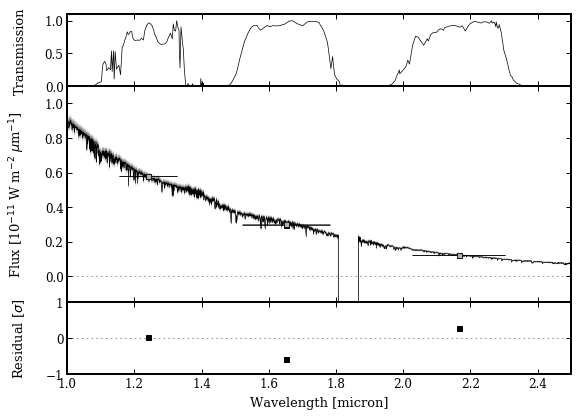

In [25]:
Image('spectrum.png')

## Photometric calibration

The magnitude of PZ Tel B can now be computed for any other filter within the wavelength coverage of the IRTF spectrum. This example calculates the flux and magnitude for the VLT/SPHERE H2 filter.

In [26]:
readcalib = species.ReadCalibration(tag='G8V_HD75732',
                                    filter_name='Paranal/SPHERE.IRDIS_D_H23_2')

Adding filter: Paranal/SPHERE.IRDIS_D_H23_2... [DONE]


In [27]:
flux = readcalib.get_flux(model_param=median)
print(f'Flux density [W m-2 micron-1] = {flux[0]:.2e}')

Flux density [W m-2 micron-1] = 3.30e-12


In [28]:
app_mag, abs_mag = readcalib.get_magnitude(model_param=median, distance=distance)
print(f'Apparent magnitude [mag]] = {app_mag[0]:.2f} +/- {app_mag[1]:.2e}')
print(f'Absolute magnitude [mag] = {abs_mag[0]:.2f} +/- {abs_mag[1]:.2e}')

Apparent magnitude [mag]] = 6.50 +/- 8.70e-04
Absolute magnitude [mag] = 3.13 +/- 6.05e-03
